In [ ]:
!curl ipinfo.io

{
  "ip": "34.143.232.219",
  "hostname": "219.232.143.34.bc.googleusercontent.com",
  "city": "Singapore",
  "region": "Singapore",
  "country": "SG",
  "loc": "1.2897,103.8501",
  "org": "AS396982 Google LLC",
  "postal": "018989",
  "timezone": "Asia/Singapore",
  "readme": "https://ipinfo.io/missingauth"
}

In [ ]:
!pip install yfinance pmdarima statsmodels arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 55.8 MB/s eta 0:00:00


# 1. PACKAGE IMPORTING AND DATA COLLECTION


## 1.1 Import dependencies

In [ ]:
# Standard library imports
import os
import sys
import math
import warnings
import itertools
from math import sqrt
from datetime import datetime
from itertools import product
from datetime import datetime, timedelta

# Third-party library imports
from arch import arch_model
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pmdarima import auto_arima
from pandas.plotting import lag_plot
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# IPython display
from IPython.display import Image, display, HTML

# Matplotlib configuration
# rcParams['figure.figsize'] = 10, 6

In [ ]:
warnings.filterwarnings("ignore")
# Use a consistent style
plt.style.use('seaborn')

## 1.2  Download Data and tickers

In [ ]:
# Download data
TICKER = "TSLA"
df_tsla = pd.read_csv(f"{TICKER}.csv")

# gs = yf.download(TICKER, start="2020-01-01", end="2021-01-01")
# df_tsla = yf.download(TICKER, start="2011-01-01", end="2021-01-01")

## 1.3 Split Data into training and testing sets

In [ ]:
# Download TSLA stock data
ticker = yf.Ticker(TICKER)
df = ticker.history(start="2023-01-01", end="2023-08-02")

# Reset index to make 'Date' a column
df.reset_index(inplace=True)

# Convert 'Date' column to the desired format
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# Set 'Date' back as index if needed
df.set_index('Date')

# Split the data into training and test sets
train_size = int(len(df['Close']) * 0.8)

train, test = train_test_split(df['Close'], test_size=0.2, shuffle=False)
# train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [ ]:
train

,Close
0,108.099998
1,113.639999
2,110.339996
3,113.059998
4,119.769997
...,...
111,258.709991
112,256.790009
113,255.899994
114,260.540009


In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-01-03,118.470001,118.800003,104.639999,108.099998,231402800,0.0,0.0
1,2023-01-04,109.110001,114.589996,107.519997,113.639999,180389000,0.0,0.0
2,2023-01-05,110.510002,111.750000,107.160004,110.339996,157986300,0.0,0.0
3,2023-01-06,103.000000,114.389999,101.809998,113.059998,220911100,0.0,0.0
4,2023-01-09,118.959999,123.519997,117.110001,119.769997,190284000,0.0,0.0


In [ ]:
df_tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [ ]:
def plot_open_vs_high(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Open'], df['High'], color='blue', edgecolor='black')
    plt.title('Open vs High')
    plt.xlabel('Open Price')
    plt.ylabel('High Price')
    plt.grid(True)
    plt.show()
    print('done')

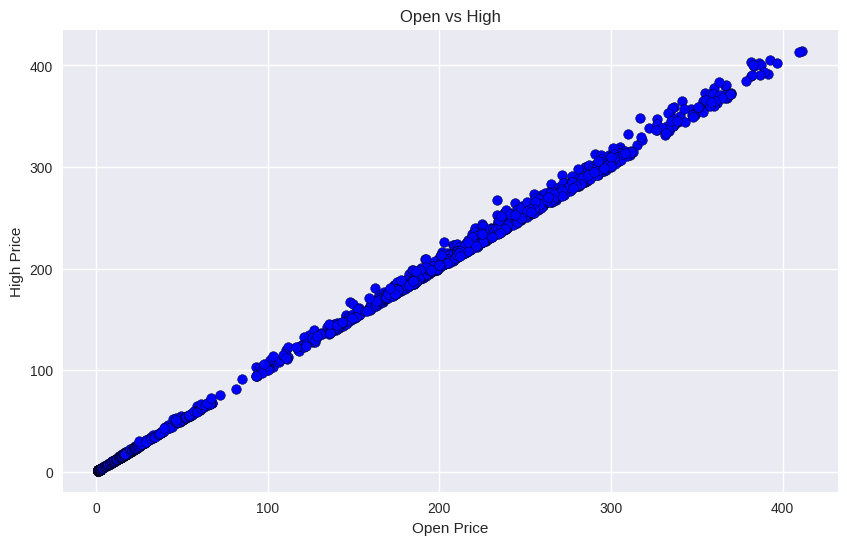

done


In [ ]:
plot_open_vs_high(df_tsla)

# 2. Feature Engineering

In [ ]:
df_tsla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3.544000e+03
mean,75.461458,77.115431,73.702271,75.445748,75.445748,9.699568e+07
std,102.511170,104.788841,100.035797,102.441247,102.441247,7.867922e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,11.516667,11.859000,11.212500,11.562500,11.562500,4.766288e+07
50%,17.463333,17.688333,17.097334,17.454333,17.454333,8.247975e+07
75%,161.144997,165.218327,157.722497,161.269997,161.269997,1.229246e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


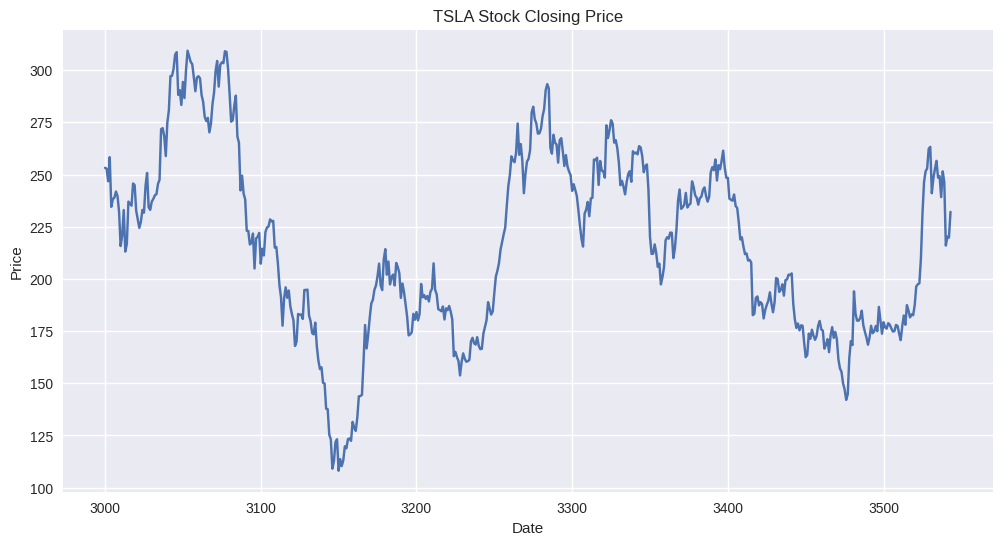

In [ ]:
# Plot the closing price
plt.figure(figsize=(12, 6))
# plt.plot(df_tsla.index, gs['Close'])
plt.plot(df_tsla['Close'][3000:])
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## 2.1 Add Extra Features

Text(0.5, 1.0, 'Relative Strength Index (RSI)')

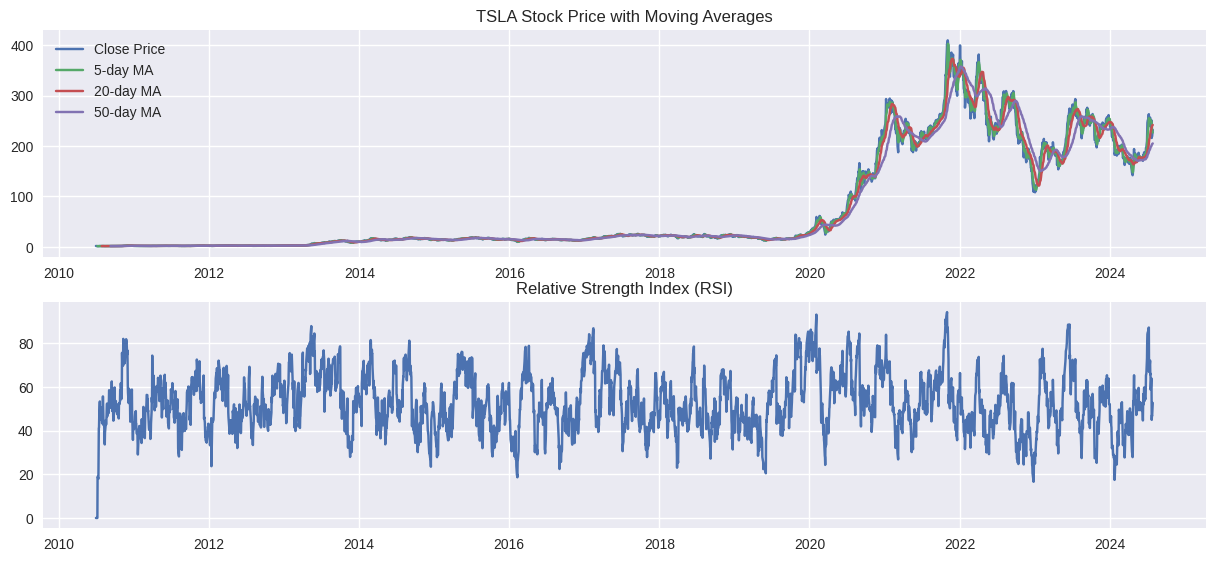

In [ ]:
# Assuming 'Date' is your date column. If it's named differently, replace 'Date' with the actual column name
if 'Date' in df_tsla.columns:
    df_tsla.set_index('Date', inplace=True)
    df_tsla.index = pd.to_datetime(df_tsla.index)
else:
    print("No 'Date' column found. Please ensure your DataFrame has a date column.")
    # You might want to add code here to create a date column if it doesn't exist


# 1. Moving Averages
df_tsla['MA5'] = df_tsla['Close'].rolling(window=5).mean()
df_tsla['MA20'] = df_tsla['Close'].rolling(window=20).mean()
df_tsla['MA50'] = df_tsla['Close'].rolling(window=50).mean()

# 2. Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    diff = data.diff()
    up = diff.clip(lower=0)
    down = -1 * diff.clip(upper=0)
    ema_up = up.ewm(com=window - 1, adjust=False).mean()
    ema_down = down.ewm(com=window - 1, adjust=False).mean()
    rs = ema_up / ema_down
    return 100 - (100 / (1 + rs))

df_tsla['RSI'] = compute_rsi(df_tsla['Close'])

# 3. Bollinger Bands
df_tsla['BB_middle'] = df_tsla['Close'].rolling(window=20).mean()
df_tsla['BB_upper'] = df_tsla['BB_middle'] + 2 * df_tsla['Close'].rolling(window=20).std()
df_tsla['BB_lower'] = df_tsla['BB_middle'] - 2 * df_tsla['Close'].rolling(window=20).std()

# 4. Trading Volume Features
df_tsla['Volume_MA5'] = df_tsla['Volume'].rolling(window=5).mean()
df_tsla['Volume_Ratio'] = df_tsla['Volume'] / df_tsla['Volume_MA5']

# 5. Price Momentum
df_tsla['Price_Momentum'] = df_tsla['Close'] - df_tsla['Close'].shift(5)

# 6. Date-based Features
df_tsla['Day_of_Week'] = df_tsla.index.dayofweek
df_tsla['Month'] = df_tsla.index.month
df_tsla['Quarter'] = df_tsla.index.quarter

# Plot some of the engineered features
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df_tsla.index, df_tsla['Close'], label='Close Price')
plt.plot(df_tsla.index, df_tsla['MA5'], label='5-day MA')
plt.plot(df_tsla.index, df_tsla['MA20'], label='20-day MA')
plt.plot(df_tsla.index, df_tsla['MA50'], label='50-day MA')
plt.title('TSLA Stock Price with Moving Averages')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_tsla.index, df_tsla['RSI'], label='RSI')
plt.title('Relative Strength Index (RSI)')

## 2.3 Plot Stock Analysis Charts

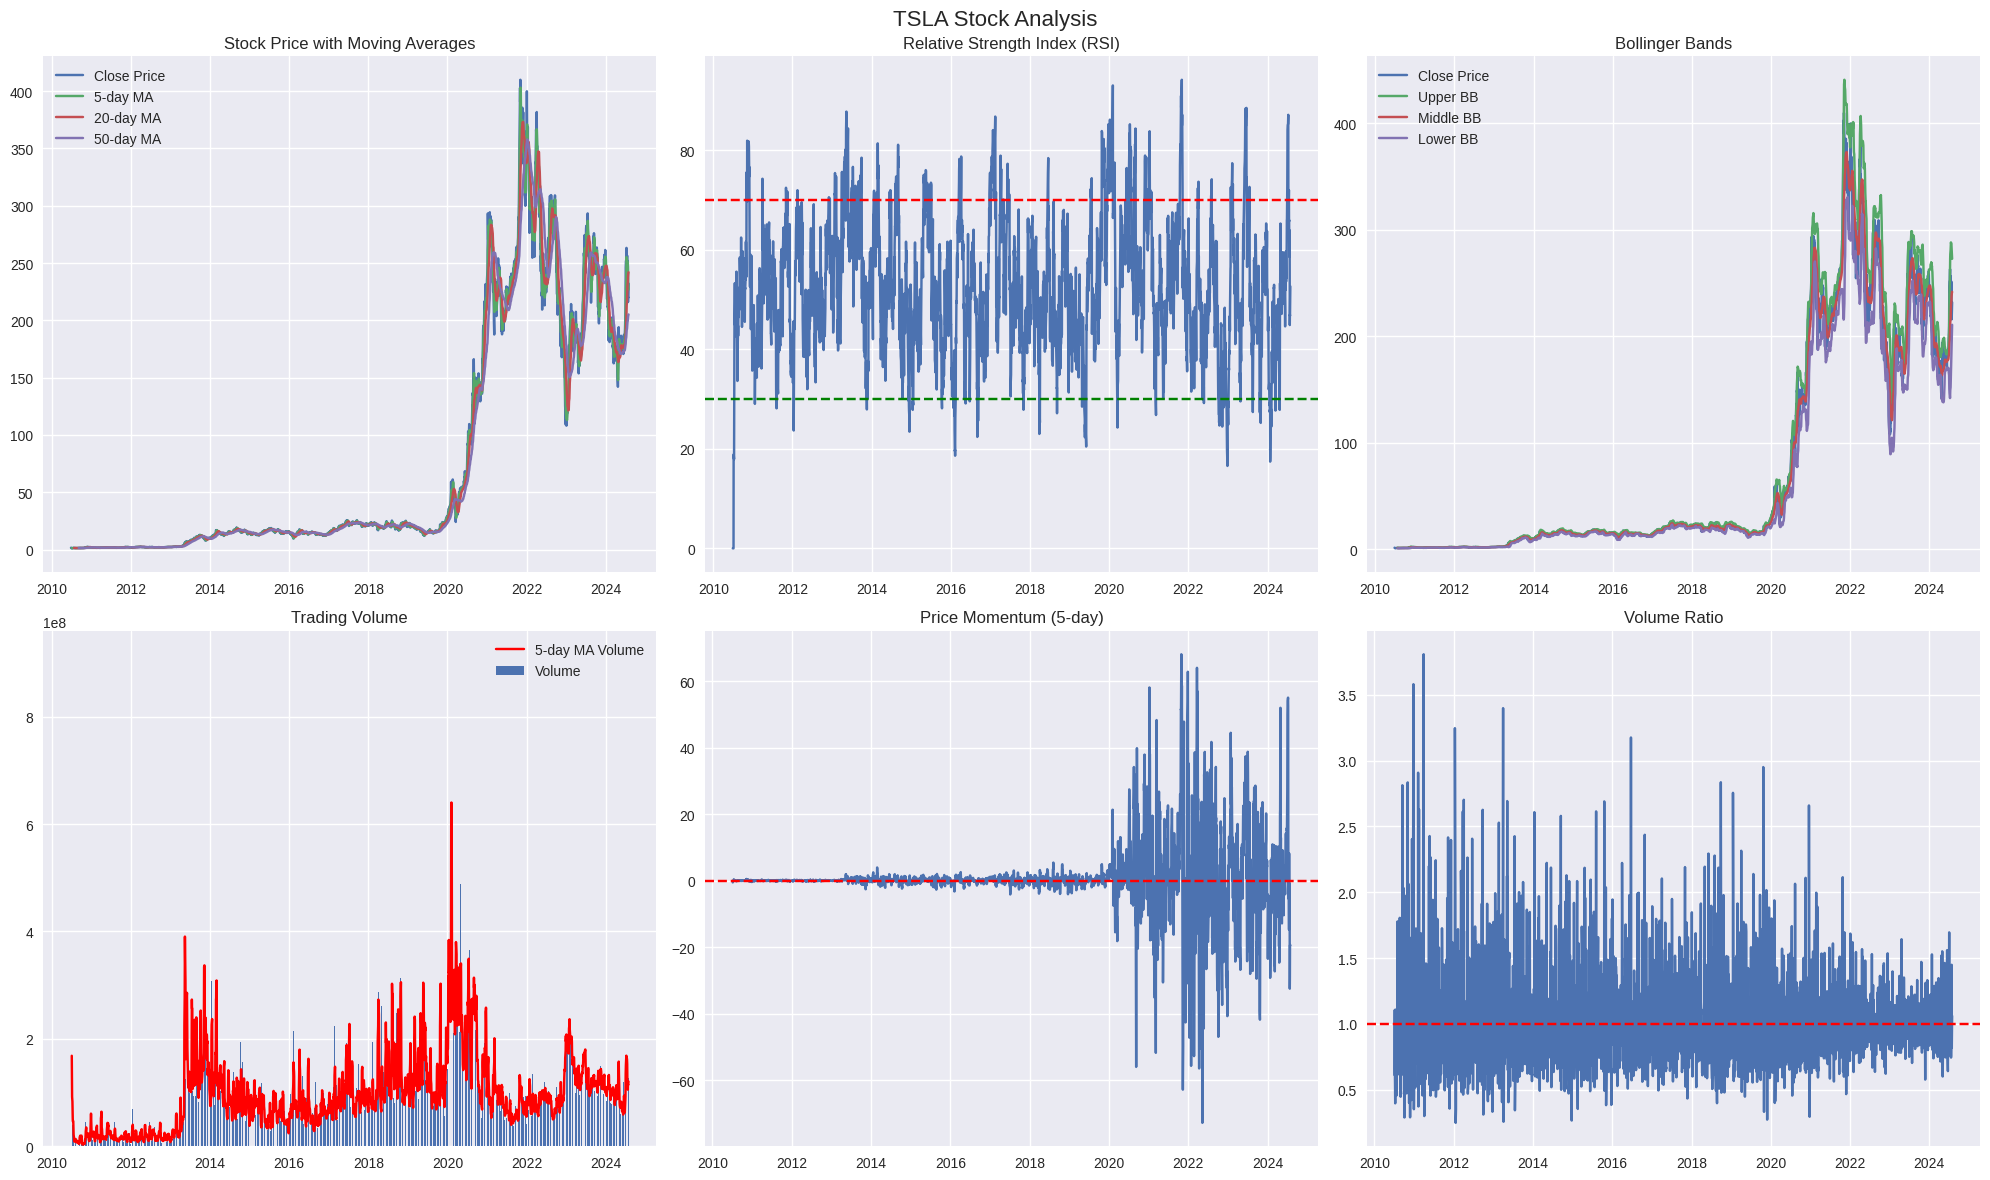

In [ ]:
# Create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('TSLA Stock Analysis', fontsize=16)

# 1. Moving Averages
axs[0, 0].plot(df_tsla.index, df_tsla['Close'], label='Close Price')
axs[0, 0].plot(df_tsla.index, df_tsla['MA5'], label='5-day MA')
axs[0, 0].plot(df_tsla.index, df_tsla['MA20'], label='20-day MA')
axs[0, 0].plot(df_tsla.index, df_tsla['MA50'], label='50-day MA')
axs[0, 0].set_title('Stock Price with Moving Averages')
axs[0, 0].legend()

# 2. RSI
axs[0, 1].plot(df_tsla.index, df_tsla['RSI'], label='RSI')
axs[0, 1].set_title('Relative Strength Index (RSI)')
axs[0, 1].axhline(y=70, color='r', linestyle='--')
axs[0, 1].axhline(y=30, color='g', linestyle='--')

# 3. Bollinger Bands
axs[0, 2].plot(df_tsla.index, df_tsla['Close'], label='Close Price')
axs[0, 2].plot(df_tsla.index, df_tsla['BB_upper'], label='Upper BB')
axs[0, 2].plot(df_tsla.index, df_tsla['BB_middle'], label='Middle BB')
axs[0, 2].plot(df_tsla.index, df_tsla['BB_lower'], label='Lower BB')
axs[0, 2].set_title('Bollinger Bands')
axs[0, 2].legend()

# 4. Volume
axs[1, 0].bar(df_tsla.index, df_tsla['Volume'], label='Volume')
axs[1, 0].plot(df_tsla.index, df_tsla['Volume_MA5'], color='r', label='5-day MA Volume')
axs[1, 0].set_title('Trading Volume')
axs[1, 0].legend()

# 5. Price Momentum
axs[1, 1].plot(df_tsla.index, df_tsla['Price_Momentum'], label='Price Momentum')
axs[1, 1].set_title('Price Momentum (5-day)')
axs[1, 1].axhline(y=0, color='r', linestyle='--')

# 6. Volume Ratio
axs[1, 2].plot(df_tsla.index, df_tsla['Volume_Ratio'], label='Volume Ratio')
axs[1, 2].set_title('Volume Ratio')
axs[1, 2].axhline(y=1, color='r', linestyle='--')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#3. Exploratory Data Analysis

In [ ]:
df_tsla.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
MA5,4
MA20,19
MA50,49
RSI,1


In [ ]:
df_tsla.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
MA5,4
MA20,19
MA50,49
RSI,1


## 3.1 AutoCorrelation and Partial Correlation


>* Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

> * Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

### 3.1.1 ACF

Autocorrelation, sometimes known as serial correlation, is the correlation of a time series with a delayed copy of itself as a function of delay. That is, it measures the similarity between observations as a function of the time lag between them. The autocorrelation function can be used basically to detect non-randomness in data and identify cyclical patterns if present.

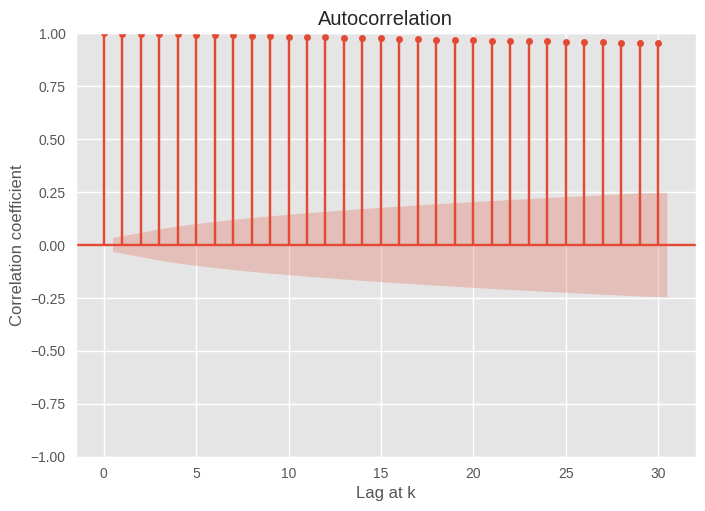

In [ ]:
# Assuming df_tsla is your DataFrame and 'Close' is the column with numerical data
numerical_data = df_tsla['Close']

plt.style.use('ggplot')
plot_acf(numerical_data, lags=30)
plt.ylabel("Correlation coefficient")
plt.xlabel('Lag at k')
plt.show()

### 3.1.2 PACF

The partial autocorrelation function of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y. The autoregressive equation of Y is nothing but the linear regression of Y with its own lags as predictors.

For example, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient α3 of Y_t-3 in the following equation:

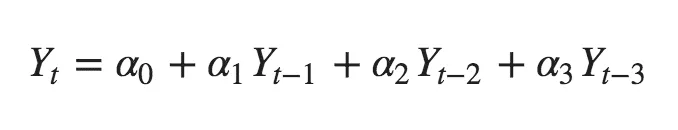

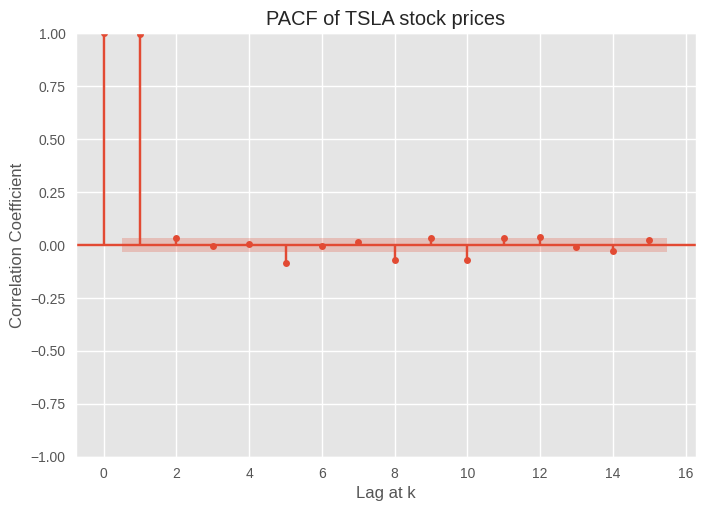

In [ ]:
numerical_data = df_tsla['Close']

plt.style.use('ggplot')
plot_pacf(numerical_data, lags=15)
plt.title("PACF of TSLA stock prices")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show()

## 3.2 Stationarity
Most of the time series are non-stationary either it gives an upward or downward trend or seasonal effect. checking the stationarity is the most important thing that we should handle if we want to make a good prediction of such time serie.

#### 3.2.1 Graphical Analysis

**1**- **Lag Plot**:
The stationarity can be checked by looking at Lag plot. A lag plot is used to checks whether the time series data is random or not, and if the data is correlated with themselves. Random data should not have any identifiable patterns, such as linear.

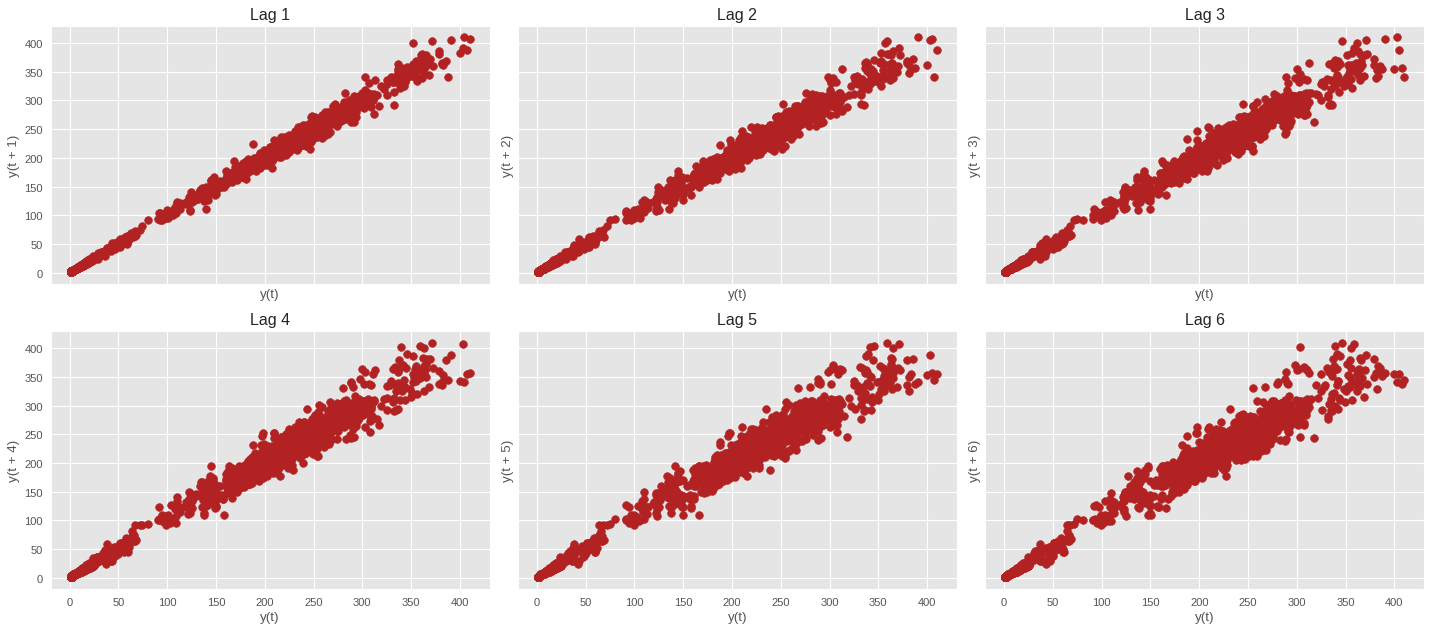

In [ ]:
# Assuming df_tsla is your DataFrame and 'Close' is the column with numerical data
numerical_data = df_tsla['Close']

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True, dpi=80)
for i, ax in enumerate(axes.flatten()[:6]):
    lag_plot(numerical_data, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.tight_layout()
plt.show()

**2**- **Rolling Statistic**:

we can check for stationarity by looking at how rolling average and rolling standard deviation behave in time.

In [ ]:
df_tsla.head()

,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,MA50,RSI,BB_middle,BB_upper,BB_lower,Volume_MA5,Volume_Ratio,Price_Momentum,Day_of_Week,Month,Quarter
Date,,,,,,,,,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,2
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3,7,3
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4,7,3
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,1.399867,NaN,NaN,0.0,NaN,NaN,NaN,168536700.0,0.611164,NaN,1,7,3


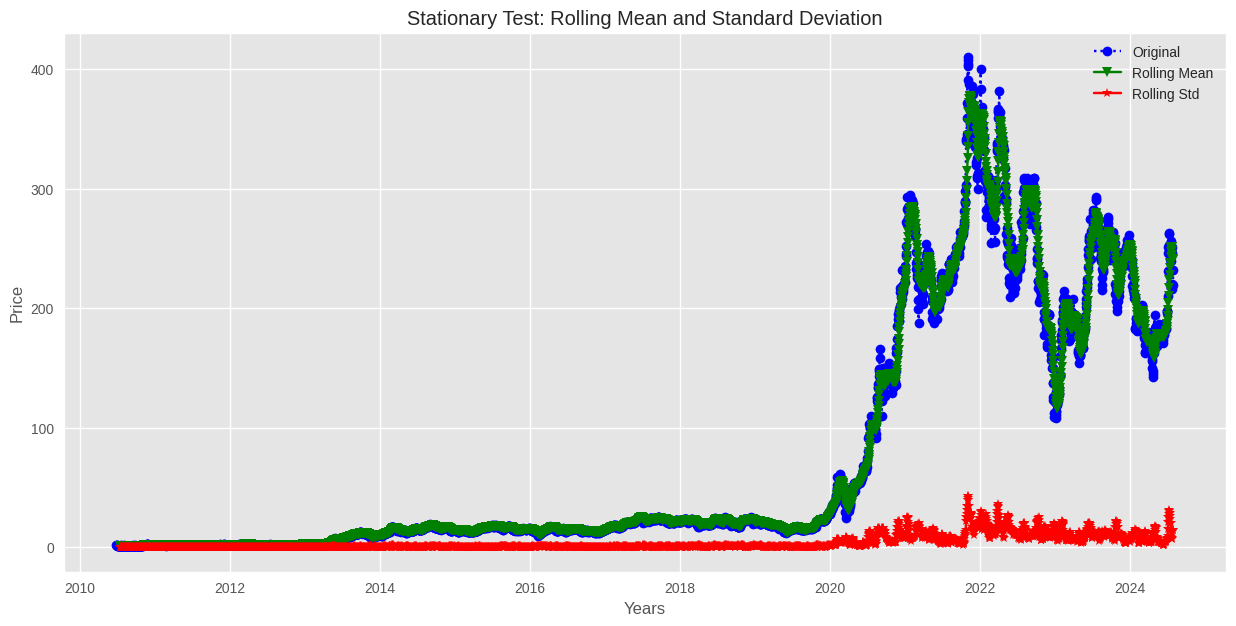

In [ ]:
# Ensure 'Close' is numeric
numerical_data = df_tsla['Close']

# Get rolling statistics for window = 12 i.e. yearly statistics
rolling_mean = numerical_data.rolling(window=12).mean()
rolling_std = numerical_data.rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Stationary Test: Rolling Mean and Standard Deviation')
plt.plot(df_tsla.index, numerical_data, 'b:', marker='o', label='Original')
plt.plot(df_tsla.index, rolling_mean, 'g-', marker='v', label='Rolling Mean')
plt.plot(df_tsla.index, rolling_std, 'r-', marker='*', label='Rolling Std')
plt.legend()
plt.show()

## 3.3 Augmented Dickey Fuller test (ADF Test):
Augmented Dickey Fuller test or (ADF Test) is the most commonly used test to detect stationarity. Here, we assume that the null hypothesis is the time series possesses a unit root and is non-stationary. Then, we collect evidence to support or reject the null hypothesis. So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis.

ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.

> * Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
> * Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
> * p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
> * p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary

> * Test statistics: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series.

In [ ]:
def stationarity_test(time_series):
    # Ensure input is a Series and has no missing values
    time_series = time_series.dropna()

    df_test = adfuller(time_series)

    print('{:25s} {:.6f}'.format("\033[1m ADF Statistic ", df_test[0]))
    print('{:25s} {:.6f}'.format("\033[1m p-value ", df_test[1]))

    if df_test[0] > df_test[4]["5%"]:
        print("\033[36m\033[1mFailed to Reject Ho - Time Series is Non-Stationary\n")
    else:
        print("\033[36m\033[1mReject Ho - Time Series is Stationary\n")

    a = pd.DataFrame([df_test[4]], index=['Critical Values'])
    return a

In [ ]:
# Lets test the stationarity
stationarity_test(df_tsla['Close'])

 ADF Statistic        -1.103908
 p-value              0.713511
Failed to Reject Ho - Time Series is Non-Stationary



,1%,5%,10%
Critical Values,-3.432212,-2.862363,-2.567208


**As** we see the test statistic is way above any critica values and the p-value also way above 0.05. then the time serie has an unit root and is non-stationary.

There is many sort of transformations to make the time series stationary for make it able to be modeled.

### 3.3.1 Differencing:
To transform the series using 'Differencing' we will use the diff() method of pandas.

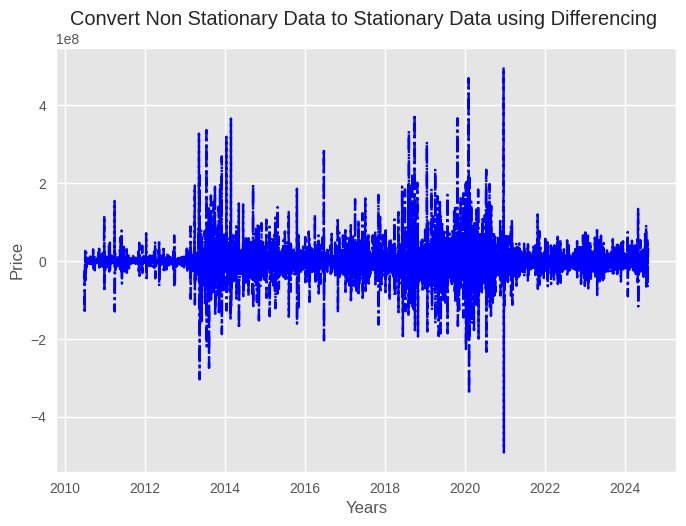

In [ ]:
df_tsla_stock = df_tsla.diff(1).bfill() # First order differencing
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_tsla_stock, 'b-.')

In [ ]:
def plot_charts(df):

    # Create a 2x2 grid for subplots
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))

    # Plot the distribution of the 'Close' prices
    sns.histplot(df['Close'], bins=50, kde=True, color='royalblue', ax=axs[0, 0])
    axs[0, 0].set_title('Distribution of Close Prices')
    axs[0, 0].set_xlabel('Close Price')
    axs[0, 0].set_ylabel('Frequency')

    # Plot the time series of the 'Close' prices
    df['Close'].plot(ax=axs[0, 1], color='royalblue', legend=True)
    axs[0, 1].set_title('Time Series of Close Prices')
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].set_ylabel('Close Price')
    axs[0, 1].legend(['Close'], loc='upper left')

    # Plot the correlation matrix
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=axs[1, 0])
    axs[1, 0].set_title('Correlation Matrix')

    # Plot the histogram of closing prices with date
    df.reset_index()['Date'].map(lambda x: x.year).hist(bins=50, color='royalblue', edgecolor='black', ax=axs[1, 1])
    axs[1, 1].set_title('Histogram of Closing Prices with Date')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].grid(True)

    # Adjust layout
    plt.tight_layout()
    return plt.show()

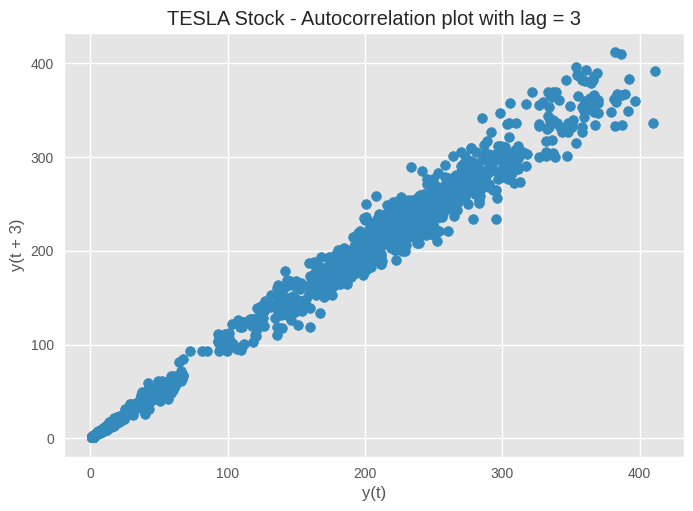

In [ ]:
plt.figure()
lag_plot(df_tsla['Open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

# 4. Autoregressive Integrated Moving Average (ARIMA)


## 4.1 Simple ARIMA

In [ ]:
class ArimaModel:
    def __init__(self, train, test):
        """
        Initializes the ARIMAStockForecast with training and testing datasets.

        Parameters:
        train (pd.Series): The training dataset.
        test (pd.Series): The testing dataset.
        """
        self.train = train
        self.test = test
        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        """
        Calculates Mean Absolute Scaled Error (MASE).

        Parameters:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.

        Returns:
        float: MASE value.
        """
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        errors = np.abs(y_true - y_pred)
        return errors.mean() / d

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        """
        Calculates Symmetric Mean Absolute Percentage Error (SMAPE).

        Parameters:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.

        Returns:
        float: SMAPE value.
        """
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.

        Parameters:
        r_squared (float): R-Squared value.
        n (int): Number of observations.
        p (int): Number of predictors.

        Returns:
        float: Adjusted R-Squared value.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.

        Parameters:
        model (ARIMA): The ARIMA model to be evaluated.
        order (tuple): The (p, d, q) order of the model.

        Returns:
        dict: A dictionary containing evaluation metrics.
        """
        results = model.fit()
        forecast = results.forecast(steps=len(self.test))
        mse = mean_squared_error(self.test, forecast)
        mae = mean_absolute_error(self.test, forecast)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((self.test - forecast) / self.test)) * 100
        smape = self.symmetric_mean_absolute_percentage_error(self.test, forecast)
        mase = self.mean_absolute_scaled_error(self.test, forecast)
        r_squared = r2_score(self.test, forecast)
        adj_r_squared = self.adjusted_r_squared(r_squared, len(self.test), len(order))
        aic_value = results.aic
        bic_value = results.bic

        return {
            'Order': order,
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'SMAPE': smape,
            'MASE': mase,
            'R_Squared': r_squared,
            'Adj_R_Squared': adj_r_squared,
            'AIC': aic_value,
            'BIC': bic_value
        }

    def grid_search(self):
        """
        Performs a grid search to find the best ARIMA model order.
        Evaluates models based on RMSE and stores the top 5 models.
        """
        p = d = q = range(0, 6)
        pdq = list(itertools.product(p, d, q))
        evaluated_orders = []

        for param in pdq:
            try:
                model = ARIMA(self.train, order=param)
                evaluation = self.evaluate_model(model, param)
                evaluated_orders.append(evaluation)
                if evaluation['RMSE'] < self.best_rmse:
                    self.best_rmse = evaluation['RMSE']
                    self.best_order = param
            except:
                continue

        self.results_df = pd.DataFrame(evaluated_orders).sort_values(by='MSE').head(5)
        self.results_df.head()

    def fit_best_model(self):
        """
        Fits the best ARIMA model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = ARIMA(self.train, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        """
        Makes forecast using the best fitted ARIMA model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.forecast(steps=len(self.test))

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()
        plt.title(f'Stock Price Forecast (ARIMA Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMA Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'ARIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMA' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMA")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

In [ ]:
# Initialize and run the forecast
arima_model = ArimaModel(train, test)

In [ ]:
# Run individual steps
arima_model.grid_search()

In [ ]:
arima_model.fit_best_model()

In [ ]:
arima_model.make_forecast()

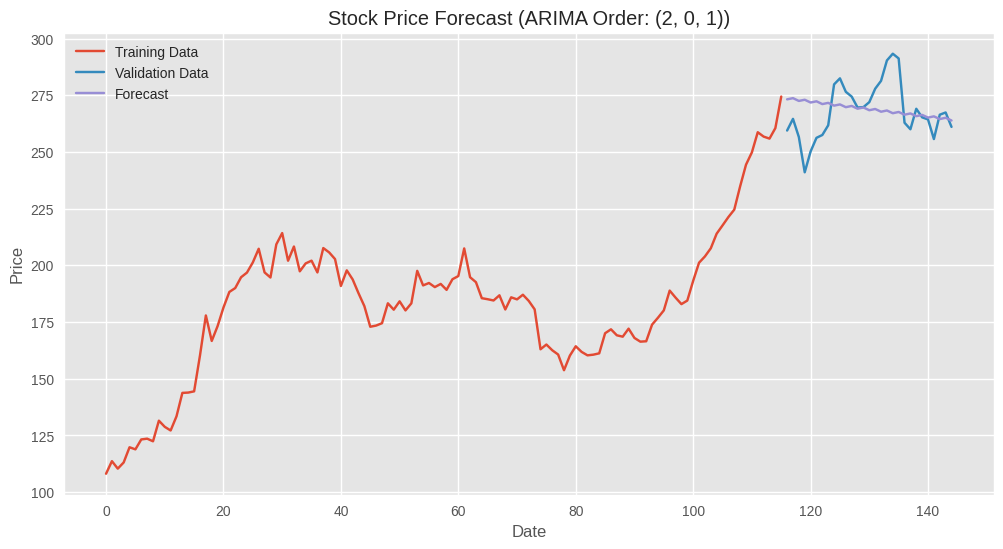

In [ ]:
arima_model.plot_results()

In [ ]:
arima_model.print_evaluation_metrics()

Final Mean Squared Error: 173.9899804456624
Final Mean Absolute Error: 10.183501699340942
Final Root Mean Squared Error: 13.190526162578292


In [ ]:
arima_model.print_model_summary()

                               ARIMA Results                                
Dep. Variable:                  Close   No. Observations:                  116
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -383.096
Date:                Thu, 08 Aug 2024   AIC                            776.193
Time:                        22:06:42   BIC                            789.961
Sample:                             0   HQIC                           781.782
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        188.2116     68.548      2.746      0.006      53.861     322.562
ar.L1         -0.0041      0.050     -0.083      0.934      -0.102       0.093
ar.L2          0.9959      0.041     24.141      0.000

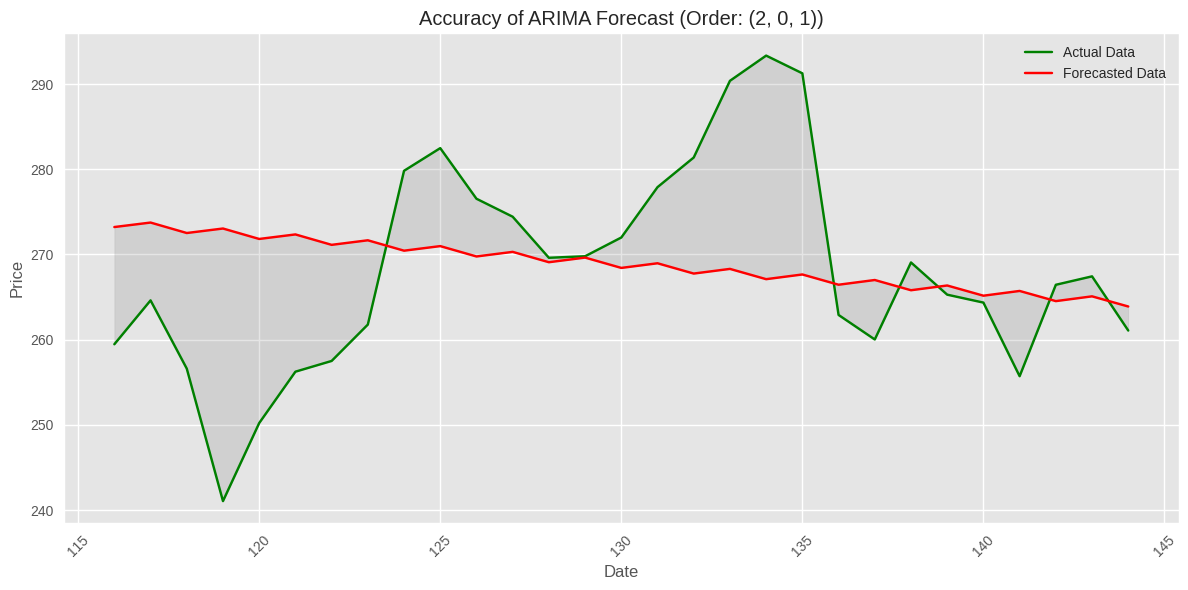

In [ ]:
arima_model.plot_accuracy()

In [ ]:
arima_model.evaluate_model()

NameError: name 'arima_model' is not defined

## 4.2 ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables)


In [ ]:
class ARIMAXModel:
    def __init__(self, ticker, start_date, end_date, exog_vars):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.exog_vars = exog_vars
        self.model_order = (0, 1, 0)
        self.train = None
        self.test = None
        self.train_exog = None
        self.test_exog = None
        self.dataset_ex_df = None
        self.history = None
        self.history_exog = None
        self.predictions = []
        self.best_orders = []

    def download_data(self):
        ticker = yf.Ticker(self.ticker)
        self.dataset_ex_df = ticker.history(start=self.start_date, end=self.end_date)
        self.dataset_ex_df.reset_index(inplace=True)
        self.dataset_ex_df['Date'] = pd.to_datetime(self.dataset_ex_df['Date'])
        self.dataset_ex_df.set_index('Date', inplace=True)

        # Drop any rows with missing values
        self.dataset_ex_df.dropna(inplace=True)

        print("Data downloaded and processed. Shape of the dataset:")
        print(self.dataset_ex_df.shape)
        print("\nFirst few rows of the dataset:")
        print(self.dataset_ex_df.head())

    def determine_arimax_order(self):
        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        model = auto_arima(endog, exogenous=exog, seasonal=False, trace=True, suppress_warnings=True)
        self.model_order = model.order
        print("Best ARIMAX model order:", self.model_order)
        print("Model summary:")
        print(model.summary())

    def grid_search_arimax_order(self):
        p_values = range(0, 6)
        d_values = range(0, 6)
        q_values = range(0, 6)
        results = []

        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = ARIMA(endog, exog=exog, order=(p, d, q))
                        model_fit = model.fit()
                        mse = mean_squared_error(endog, model_fit.fittedvalues)
                        results.append(((p, d, q), mse, model_fit))
                        print(f'ARIMAX order {(p, d, q)} MSE={mse}')
                    except Exception as e:
                        continue

        results.sort(key=lambda x: x[1])
        self.best_orders = results[:5]
        self.model_order = self.best_orders[0][0]

        metrics = ['Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC']
        metrics_data = []

        for order, mse, model_fit in self.best_orders:
            y_true = endog
            y_pred = model_fit.fittedvalues
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
            mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))  # naive forecast method
            r_squared = r2_score(y_true, y_pred)
            adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - len(model_fit.params) - 1)
            aic = model_fit.aic
            bic = model_fit.bic

            metrics_data.append([order, mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic])

        best_orders_df = pd.DataFrame(metrics_data, columns=metrics)
        print("Top 5 ARIMAX model orders with evaluation metrics:")
        print(best_orders_df)

        return best_orders_df

    def arima_forecast(self, history, history_exog, exog):
        model = ARIMA(history, exog=np.array(history_exog), order=self.model_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1, exog=exog)
        return forecast[0]

    def walk_forward_validation(self, test_size=0.2):
        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        self.train, self.test, self.train_exog, self.test_exog = train_test_split(
            endog, exog, test_size=test_size, shuffle=False
        )

        self.history = [x for x in self.train]
        self.history_exog = self.train_exog.values.tolist()

        for i in range(len(self.test)):
            exog = self.test_exog.iloc[i:i+1].values
            yhat = self.arima_forecast(self.history, self.history_exog, exog)
            self.predictions.append(yhat)
            obs = self.test.iloc[i]
            self.history.append(obs)
            self.history_exog.append(exog[0])
            print('Predicted: ' + str(yhat) + ', Expected: ' + str(obs))

        mse = np.mean((self.test - self.predictions) ** 2)
        rmse = np.sqrt(mse)
        print('Test RMSE: ' + str(rmse))

        # Plotting the results
        plt.figure(figsize=(14, 7))
        plt.plot(self.train.index, self.train.values, label='Training Data')
        plt.plot(self.test.index, self.test.values, label='Testing Data', color='orange')
        plt.plot(self.test.index, self.predictions, label=f'Forecast (Order: {self.model_order})', color='green')
        plt.title(f'ARIMAX Forecast for {self.ticker} (Order: {self.model_order})')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()


In [ ]:
arimax_model = ARIMAXModel(ticker='TSLA', start_date='2023-01-01', end_date='2023-08-02', exog_vars=['Open', 'High', 'Low', 'Volume'])

In [ ]:
arimax_model.download_data()

Data downloaded and processed. Shape of the dataset:
(145, 7)

First few rows of the dataset:
                                 Open        High         Low       Close  \
Date                                                                        
2023-01-03 00:00:00-05:00  118.470001  118.800003  104.639999  108.099998   
2023-01-04 00:00:00-05:00  109.110001  114.589996  107.519997  113.639999   
2023-01-05 00:00:00-05:00  110.510002  111.750000  107.160004  110.339996   
2023-01-06 00:00:00-05:00  103.000000  114.389999  101.809998  113.059998   
2023-01-09 00:00:00-05:00  118.959999  123.519997  117.110001  119.769997   

                              Volume  Dividends  Stock Splits  
Date                                                           
2023-01-03 00:00:00-05:00  231402800        0.0           0.0  
2023-01-04 00:00:00-05:00  180389000        0.0           0.0  
2023-01-05 00:00:00-05:00  157986300        0.0           0.0  
2023-01-06 00:00:00-05:00  220911100        0.

In [ ]:
best_orders_df = arimax_model.grid_search_arimax_order()

ARIMAX order (0, 0, 0) MSE=5.306672693316062
ARIMAX order (0, 0, 1) MSE=5.1926835880330415
ARIMAX order (0, 0, 2) MSE=4.9636339692888525
ARIMAX order (0, 0, 3) MSE=4.961290774307411
ARIMAX order (0, 0, 4) MSE=4.918142016189183
ARIMAX order (0, 0, 5) MSE=4.827592521956467
ARIMAX order (0, 1, 0) MSE=14.673798199991145
ARIMAX order (0, 1, 1) MSE=12.082263167208195
ARIMAX order (0, 1, 2) MSE=12.119322136366092
ARIMAX order (0, 1, 3) MSE=11.920346756410185
ARIMAX order (0, 1, 4) MSE=11.804272625277715
ARIMAX order (0, 1, 5) MSE=11.797743490677172
ARIMAX order (0, 2, 0) MSE=40.89450979225551
ARIMAX order (0, 2, 1) MSE=40.88352172604031
ARIMAX order (0, 2, 2) MSE=40.88351777166285
ARIMAX order (0, 2, 3) MSE=22.101292385857626
ARIMAX order (0, 2, 4) MSE=40.88351319425842
ARIMAX order (0, 2, 5) MSE=22.084061458503363
ARIMAX order (0, 3, 0) MSE=117.08979888068339
ARIMAX order (0, 3, 1) MSE=116.95401594852248
ARIMAX order (0, 3, 2) MSE=42.650281208475434
ARIMAX order (0, 3, 3) MSE=116.95387437675

In [ ]:
arimax_model.determine_arimax_order()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=973.067, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=975.062, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=975.062, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=974.346, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=977.030, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.430 seconds
Best ARIMAX model order: (0, 1, 0)
Model summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  145
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -484.534
Date:                Thu, 08 Aug 2024   AIC                            973.067
Time:                        22:07:38   BIC                            979.007
Sample:                             0   HQIC     

Predicted: 262.9169230932859, Expected: 259.4599914550781
Predicted: 261.2917988185367, Expected: 264.6099853515625
Predicted: 260.2001905676128, Expected: 256.6000061035156
Predicted: 250.21337440925043, Expected: 241.0500030517578
Predicted: 241.11831852454785, Expected: 250.2100067138672
Predicted: 259.1981585791606, Expected: 256.239990234375
Predicted: 255.43800082115922, Expected: 257.5
Predicted: 264.2988327834613, Expected: 261.7699890136719
Predicted: 276.6694433301509, Expected: 279.82000732421875
Predicted: 280.002578751011, Expected: 282.4800109863281
Predicted: 276.1503332534594, Expected: 276.5400085449219
Predicted: 277.76780087790604, Expected: 274.42999267578125
Predicted: 265.3103479319527, Expected: 269.6099853515625
Predicted: 272.90698029746375, Expected: 269.7900085449219
Predicted: 272.4250307985218, Expected: 271.989990234375
Predicted: 274.1057499073984, Expected: 277.8999938964844
Predicted: 285.1236872811629, Expected: 281.3800048828125
Predicted: 285.2757735

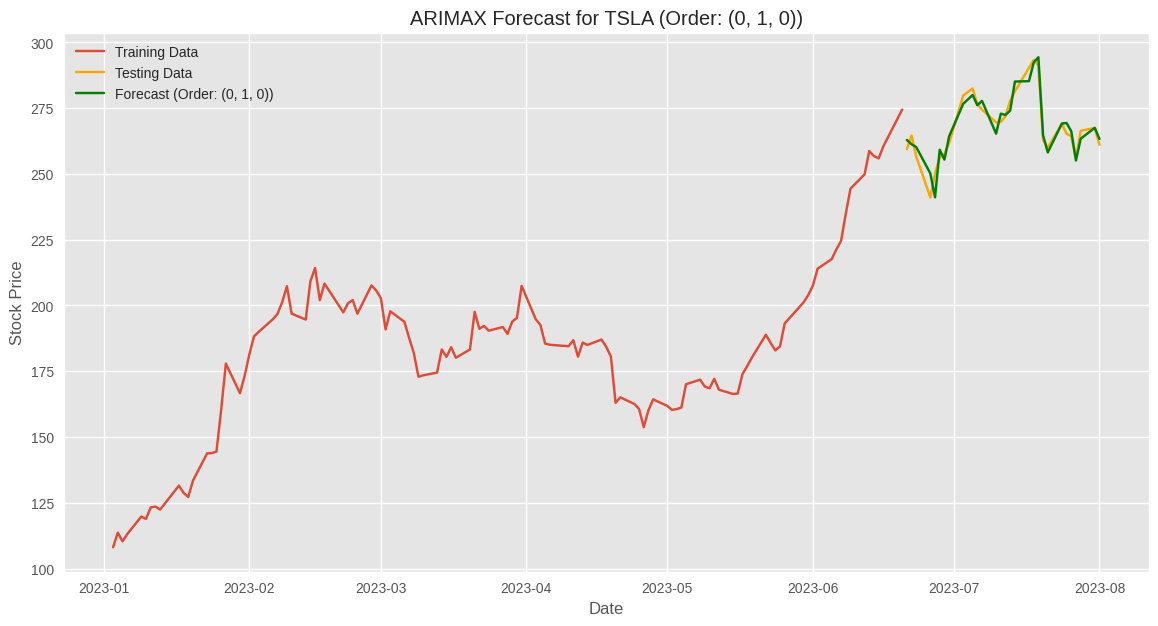

In [ ]:
# arimax_model.determine_arimax_order()  # Optionally, use auto_arima for optimal searching
arimax_model.walk_forward_validation()

In [ ]:
print("Top 5 ARIMAX model orders with their evaluation metrics:")
best_orders_df

Top 5 ARIMAX model orders with their evaluation metrics:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
0,"(4, 0, 5)",4.704240,1.678795,2.168926,0.866154,0.865537,inf,0.997696,0.997428,666.627884,711.278890
1,"(5, 0, 3)",4.706001,1.681928,2.169332,0.868483,0.867868,inf,0.997695,0.997447,664.490934,706.165206
2,"(5, 0, 4)",4.706626,1.681482,2.169476,0.868252,0.867624,inf,0.997695,0.997427,666.714425,711.365431
3,"(4, 0, 4)",4.710502,1.683103,2.170369,0.868606,0.867980,inf,0.997693,0.997444,664.823528,706.497800
4,"(5, 0, 0)",4.712198,1.695720,2.170760,0.874477,0.873834,inf,0.997692,0.997501,658.563326,691.307397


In [ ]:
class ARIMAXModel:
    def __init__(self, train, test, train_exog, test_exog, exog_vars):
        """
        Initializes the ARIMAXModel with the given parameters.

        Parameters:
        train (pd.Series): The training dataset.
        test (pd.Series): The testing dataset.
        train_exog (pd.DataFrame): The training exogenous variables.
        test_exog (pd.DataFrame): The testing exogenous variables.
        exog_vars (list): List of exogenous variables to include in the model.
        """
        self.train = train
        self.test = test
        self.train_exog = train_exog
        self.test_exog = test_exog
        self.exog_vars = exog_vars
        self.model_order = (0, 1, 0)
        self.history = list(train)
        self.history_exog = train_exog.values.tolist()
        self.predictions = []
        self.best_orders = []
        self.best_model = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    def determine_arimax_order(self):
        """
        Determines the best ARIMAX model order using auto_arima.
        """
        from pmdarima import auto_arima
        endog = self.train
        exog = self.train_exog

        model = auto_arima(endog, exogenous=exog, seasonal=False, trace=True, suppress_warnings=True)
        self.model_order = model.order
        print("Best ARIMAX model order:", self.model_order)
        print("Model summary:")
        print(model.summary())

    def grid_search_arimax_order(self):
        """
        Performs a grid search to find the best ARIMAX model order.
        """
        p_values = range(0, 6)
        d_values = range(0, 6)
        q_values = range(0, 6)
        results = []

        endog = self.train
        exog = self.train_exog

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = ARIMA(endog, exog=exog, order=(p, d, q))
                        model_fit = model.fit()
                        mse = mean_squared_error(endog, model_fit.fittedvalues)
                        results.append(((p, d, q), mse, model_fit))
                        print(f'ARIMAX order {(p, d, q)} MSE={mse}')
                    except Exception as e:
                        continue

        results.sort(key=lambda x: x[1])
        self.best_orders = results[:5]
        self.model_order = self.best_orders[0][0]

        metrics = ['Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC']
        metrics_data = []

        for order, mse, model_fit in self.best_orders:
            y_true = endog
            y_pred = model_fit.fittedvalues
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
            mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))  # naive forecast method
            r_squared = r2_score(y_true, y_pred)
            adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - len(model_fit.params) - 1)
            aic = model_fit.aic
            bic = model_fit.bic

            metrics_data.append([order, mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic])

        best_orders_df = pd.DataFrame(metrics_data, columns=metrics)
        print("Top 5 ARIMAX model orders with evaluation metrics:")
        best_orders_df.head()

        return best_orders_df

    def fit_best_model(self):
        """
        Fits the best ARIMAX model found during grid search.
        """
        if self.best_orders:
            best_order = self.best_orders[0][0]
            self.best_model = ARIMA(self.train, exog=self.train_exog, order=best_order).fit()
        else:
            raise ValueError("No best model order found. Please run grid_search_arimax_order first.")

    def arimax_forecast(self, history, history_exog, exog):
        """
        Forecasts the next value using the ARIMAX model.

        Parameters:
        history (list): The historical endogenous data.
        history_exog (list): The historical exogenous data.
        exog (array-like): The exogenous variables for the forecast period.

        Returns:
        float: The forecasted value.
        """
        model = ARIMA(history, exog=np.array(history_exog), order=self.model_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1, exog=exog)
        return forecast[0]

    def walk_forward_validation(self):
        """
        Performs walk-forward validation on the dataset.
        """
        for i in range(len(self.test)):
            exog = self.test_exog.iloc[i:i+1].values
            yhat = self.arimax_forecast(self.history, self.history_exog, exog)
            self.predictions.append(yhat)
            obs = self.test.iloc[i]
            self.history.append(obs)
            self.history_exog.append(exog[0])
            print('Predicted: ' + str(yhat) + ', Expected: ' + str(obs))

        mse = mean_squared_error(self.test, self.predictions)
        rmse = np.sqrt(mse)
        print('Test RMSE: ' + str(rmse))

        # Plotting the results
        plt.figure(figsize=(14, 7))
        plt.plot(self.train.index, self.train.values, label='Training Data')
        plt.plot(self.test.index, self.test.values, label='Testing Data', color='orange')
        plt.plot(self.test.index, self.predictions, label=f'Forecast (Order: {self.model_order})', color='green')
        plt.title(f'ARIMAX Forecast (Order: {self.model_order})')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
        plt.legend()
        plt.tight_layout()  # Adjust the plot to make sure everything fits without overlap
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if not self.predictions:
            raise ValueError("Predictions not made. Please run walk_forward_validation first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.predictions, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.predictions, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMAX Forecast (Order: {self.model_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
        plt.tight_layout()  # Adjust the plot to make sure everything fits without overlap
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if not self.predictions:
            raise ValueError("Predictions not made. Please run walk_forward_validation first.")
        mse = mean_squared_error(self.test, self.predictions)
        mae = mean_absolute_error(self.test, self.predictions)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'ARIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        original_summary = self.best_model.summary().as_text()
        modified_summary = original_summary.replace("SARIMAX", "ARIMA")
        print(modified_summary)
        print("\nModel Coefficients:")
        for param_name, value in zip(self.best_model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

In [ ]:
# Example usage
ticker = yf.Ticker("TSLA")
df = ticker.history(start="2023-01-01", end="2023-08-02")
df.reset_index(inplace=True)
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df.set_index('Date', inplace=True)

# Exogenous variables example (you can customize this as needed)
exog_vars = ['Volume', 'Open', 'High', 'Low']
for var in exog_vars:
    if var not in df.columns:
        raise ValueError(f"Exogenous variable {var} not found in the data.")

# Split the data into training and test sets
train_size = int(len(df['Close']) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

# Split exogenous variables into training and testing sets
train_exog = df[exog_vars].iloc[:train_size]
test_exog = df[exog_vars].iloc[train_size:]

# Initialize the ARIMAXModel
arimax_model = ARIMAXModel(train, test, train_exog, test_exog, exog_vars)

In [ ]:
# Run individual steps
arimax_model.determine_arimax_order()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=752.047, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=754.518, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=756.511, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=756.511, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=758.385, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=754.444, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=755.350, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=754.740, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=754.740, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=754.925, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=753.307, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=754.496, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=756.730, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=751.964, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=754.2

In [ ]:
best_orders_df = arimax_model.grid_search_arimax_order()

ARIMAX order (0, 0, 0) MSE=5.207543058399871
ARIMAX order (0, 0, 1) MSE=5.1456497980446265
ARIMAX order (0, 0, 2) MSE=4.932638225071808
ARIMAX order (0, 0, 3) MSE=4.876200158346042
ARIMAX order (0, 0, 4) MSE=4.750896294389185
ARIMAX order (0, 0, 5) MSE=4.709900117559851
ARIMAX order (0, 1, 0) MSE=15.055395327706375
ARIMAX order (0, 1, 1) MSE=12.710909171969073
ARIMAX order (0, 1, 2) MSE=12.674740738204074
ARIMAX order (0, 1, 3) MSE=12.635232726875316
ARIMAX order (0, 1, 4) MSE=12.187275442570636
ARIMAX order (0, 1, 5) MSE=12.158327112339805
ARIMAX order (0, 2, 0) MSE=41.80712077303612
ARIMAX order (0, 2, 1) MSE=41.797383290657685
ARIMAX order (0, 2, 2) MSE=41.79737937157127
ARIMAX order (0, 2, 3) MSE=41.79737815434184
ARIMAX order (0, 2, 4) MSE=24.093292557558193
ARIMAX order (0, 2, 5) MSE=23.228979789204097
ARIMAX order (0, 3, 0) MSE=116.93409270524569
ARIMAX order (0, 3, 1) MSE=116.8144409329435
ARIMAX order (0, 3, 2) MSE=116.81437178136727
ARIMAX order (0, 3, 3) MSE=116.814309412653

In [ ]:
arimax_model.fit_best_model()

Predicted: 262.0338554283475, Expected: 259.4599914550781
Predicted: 260.4759274200289, Expected: 264.6099853515625
Predicted: 255.8570124031257, Expected: 256.6000061035156
Predicted: 248.5241221349538, Expected: 241.0500030517578
Predicted: 247.99263463256742, Expected: 250.2100067138672
Predicted: 258.9268406619873, Expected: 256.239990234375
Predicted: 258.6536703958732, Expected: 257.5
Predicted: 263.94199695828166, Expected: 261.7699890136719
Predicted: 281.3579241708943, Expected: 279.82000732421875
Predicted: 283.48886565969747, Expected: 282.4800109863281
Predicted: 275.84895311557113, Expected: 276.5400085449219
Predicted: 276.85083009832545, Expected: 274.42999267578125
Predicted: 266.6588801553593, Expected: 269.6099853515625
Predicted: 268.68723966485993, Expected: 269.7900085449219
Predicted: 272.6790069819288, Expected: 271.989990234375
Predicted: 275.1409852687938, Expected: 277.8999938964844
Predicted: 282.89160525283114, Expected: 281.3800048828125
Predicted: 289.1933

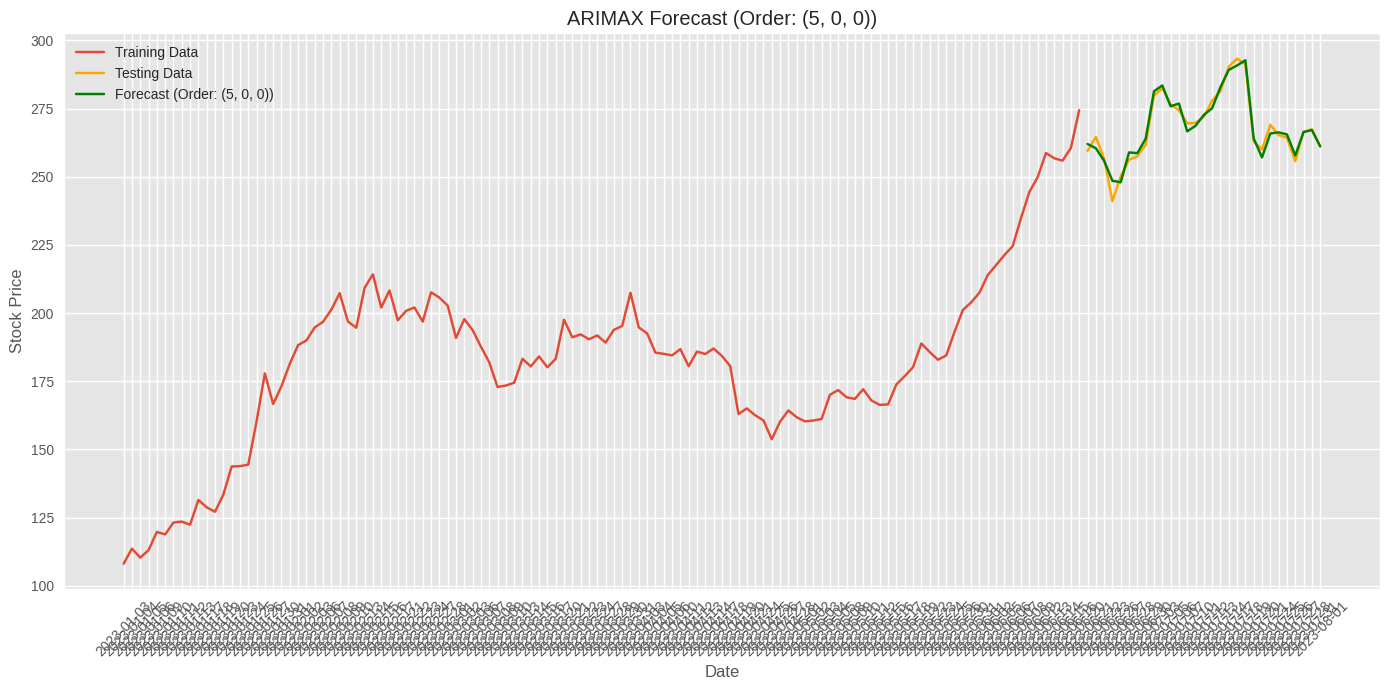

In [ ]:
arimax_model.walk_forward_validation()

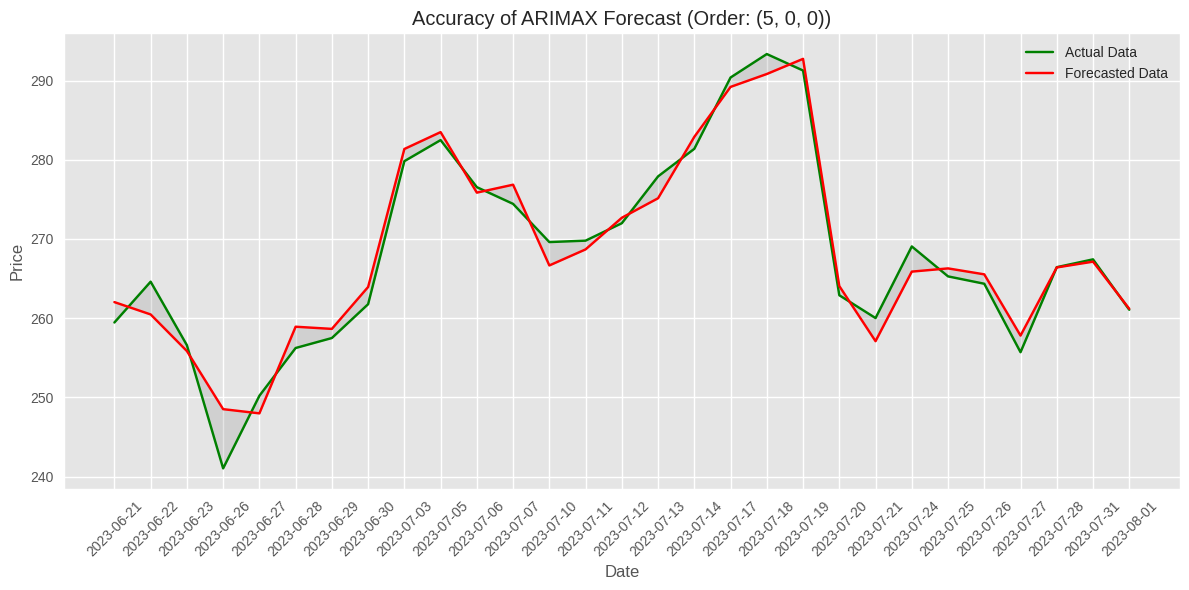

In [ ]:
arimax_model.plot_accuracy()

In [ ]:
arimax_model.print_evaluation_metrics()

Final Mean Squared Error: 5.6947527435002225
Final Mean Absolute Error: 1.8965256716581491
Final Root Mean Squared Error: 2.3863681072919625


In [ ]:
arimax_model.print_model_summary()

                               ARIMA Results                                
Dep. Variable:                  Close   No. Observations:                  116
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -253.982
Date:                Thu, 08 Aug 2024   AIC                            529.964
Time:                        22:09:33   BIC                            560.253
Sample:                             0   HQIC                           542.260
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7297    4.2e-06   4.12e+05      0.000       1.730       1.730
Volume     -1.237e-09   3.82e-09     -0.324      0.746   -8.72e-09    6.25e-09
Open          -0.6699      0.001   -568.768      0.000

#### ARIMAX with percentage change as exogenous variable

In [ ]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf

class ARIMAXModel:
    def __init__(self, train, test, train_exog, test_exog, exog_vars):
        """
        Initializes the ARIMAXModel with the given parameters.

        Parameters:
        train (pd.Series): The training dataset.
        test (pd.Series): The testing dataset.
        train_exog (pd.DataFrame): The training exogenous variables.
        test_exog (pd.DataFrame): The testing exogenous variables.
        exog_vars (list): List of exogenous variables to include in the model.
        """
        self.train = train
        self.test = test
        self.train_exog = train_exog
        self.test_exog = test_exog
        self.exog_vars = exog_vars
        self.model_order = (0, 1, 0)
        self.history = list(train)
        self.history_exog = train_exog.values.tolist()
        self.predictions = []
        self.best_orders = []
        self.best_model = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    def determine_arimax_order(self):
        """
        Determines the best ARIMAX model order using auto_arima.
        """
        from pmdarima import auto_arima
        endog = self.train
        exog = self.train_exog

        model = auto_arima(endog, exogenous=exog, seasonal=False, trace=True, suppress_warnings=True)
        self.model_order = model.order
        print("Best ARIMAX model order:", self.model_order)
        print("Model summary:")
        print(model.summary())

    def grid_search_arimax_order(self):
        """
        Performs a grid search to find the best ARIMAX model order.
        """
        p_values = range(0, 6)
        d_values = range(0, 3)
        q_values = range(0, 6)
        results = []

        endog = self.train
        exog = self.train_exog

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = ARIMA(endog, exog=exog, order=(p, d, q))
                        model_fit = model.fit()
                        mse = mean_squared_error(endog, model_fit.fittedvalues)
                        results.append(((p, d, q), mse, model_fit))
                        print(f'ARIMAX order {(p, d, q)} MSE={mse}')
                    except Exception as e:
                        continue

        results.sort(key=lambda x: x[1])
        self.best_orders = results[:5]
        self.model_order = self.best_orders[0][0]

        metrics = ['Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC']
        metrics_data = []

        for order, mse, model_fit in self.best_orders:
            y_true = endog
            y_pred = model_fit.fittedvalues
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
            mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))  # naive forecast method
            r_squared = r2_score(y_true, y_pred)
            adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - len(model_fit.params) - 1)
            aic = model_fit.aic
            bic = model_fit.bic

            metrics_data.append([order, mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic])

        best_orders_df = pd.DataFrame(metrics_data, columns=metrics)
        print("Top 5 ARIMAX model orders with evaluation metrics:")
        print(best_orders_df)

        return best_orders_df

    def fit_best_model(self):
        """
        Fits the best ARIMAX model found during grid search.
        """
        if self.best_orders:
            best_order = self.best_orders[0][0]
            self.best_model = ARIMA(self.train, exog=self.train_exog, order=best_order).fit()
        else:
            raise ValueError("No best model order found. Please run grid_search_arimax_order first.")

    def arimax_forecast(self, history, history_exog, exog):
        """
        Forecasts the next value using the ARIMAX model.

        Parameters:
        history (list): The historical endogenous data.
        history_exog (list): The historical exogenous data.
        exog (array-like): The exogenous variables for the forecast period.

        Returns:
        float: The forecasted value.
        """
        model = ARIMA(history, exog=np.array(history_exog), order=self.model_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1, exog=exog)
        return forecast[0]

    def walk_forward_validation(self):
        """
        Performs walk-forward validation on the dataset.
        """
        for i in range(len(self.test)):
            exog = self.test_exog.iloc[i:i+1].values
            yhat = self.arimax_forecast(self.history, self.history_exog, exog)
            self.predictions.append(yhat)
            obs = self.test.iloc[i]
            self.history.append(obs)
            self.history_exog.append(exog[0])
            print('Predicted: ' + str(yhat) + ', Expected: ' + str(obs))

        mse = mean_squared_error(self.test, self.predictions)
        rmse = np.sqrt(mse)
        print('Test RMSE: ' + str(rmse))

        # Plotting the results
        plt.figure(figsize=(14, 7))
        plt.plot(self.train.index, self.train.values, label='Training Data')
        plt.plot(self.test.index, self.test.values, label='Testing Data', color='orange')
        plt.plot(self.test.index, self.predictions, label=f'Forecast (Order: {self.model_order})', color='green')
        plt.title(f'ARIMAX Forecast (Order: {self.model_order})')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
        plt.legend()
        plt.tight_layout()  # Adjust the plot to make sure everything fits without overlap
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if not self.predictions:
            raise ValueError("Predictions not made. Please run walk_forward_validation first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.predictions, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.predictions, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMAX Forecast (Order: {self.model_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
        plt.tight_layout()  # Adjust the plot to make sure everything fits without overlap
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if not self.predictions:
            raise ValueError("Predictions not made. Please run walk_forward_validation first.")
        mse = mean_squared_error(self.test, self.predictions)
        mae = mean_absolute_error(self.test, self.predictions)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'ARIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        original_summary = self.best_model.summary().as_text()
        modified_summary = original_summary.replace("SARIMAX", "ARIMA")
        print(modified_summary)
        print("\nModel Coefficients:")
        for param_name, value in zip(self.best_model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

In [ ]:
# Example usage
ticker = yf.Ticker("TSLA")
df = ticker.history(start="2023-01-01", end="2023-08-02")
df.reset_index(inplace=True)
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df.set_index('Date', inplace=True)

# Calculate percentage change of the close price
df['Close_pct_change'] = df['Close'].pct_change().dropna()

# Exogenous variables example (you can customize this as needed)
exog_vars = ['Volume', 'Open', 'High', 'Low']
for var in exog_vars:
    if var not in df.columns:
        raise ValueError(f"Exogenous variable {var} not found in the data.")

# Align the data to remove the first row with NaN percentage change
df = df.dropna(subset=['Close_pct_change'])

# Split the data into training and test sets
train_size = int(len(df['Close_pct_change']) * 0.8)
train, test = df['Close_pct_change'][:train_size], df['Close_pct_change'][train_size:]

# Split exogenous variables into training and testing sets
train_exog = df[exog_vars].iloc[:train_size]
test_exog = df[exog_vars].iloc[train_size:]

# Initialize the ARIMAXModel
arimax_model = ARIMAXModel(train, test, train_exog, test_exog, exog_vars)

In [ ]:
# Run individual steps
arimax_model.determine_arimax_order()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-434.101, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-433.454, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-431.657, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-431.653, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-438.462, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-429.654, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-437.441, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-440.510, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-430.622, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-436.828, Time=0.16 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-438.587, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-434.927, Time=0.11 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-437.589, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-440.395, Time=0.17 sec

Best model:  ARIMA(1,0,3)(0,0,0)

In [ ]:
best_orders_df = arimax_model.grid_search_arimax_order()

ARIMAX order (0, 0, 0) MSE=0.0007146418670445945
ARIMAX order (0, 0, 1) MSE=0.0007141993225105317
ARIMAX order (0, 0, 2) MSE=0.0007005265103143568
ARIMAX order (0, 0, 3) MSE=0.0006928296989234556
ARIMAX order (0, 0, 4) MSE=0.0006858418189262012
ARIMAX order (0, 0, 5) MSE=0.0006848609210703192
ARIMAX order (0, 1, 0) MSE=0.0015719384763920915
ARIMAX order (0, 1, 1) MSE=0.0013443168626026882
ARIMAX order (0, 1, 2) MSE=0.0013767574995910453
ARIMAX order (0, 1, 3) MSE=0.0012767185317195994
ARIMAX order (0, 1, 4) MSE=0.0012788532022311625
ARIMAX order (0, 1, 5) MSE=0.0012742004562735754
ARIMAX order (0, 2, 0) MSE=0.004535667894699285
ARIMAX order (0, 2, 1) MSE=0.002816127780368659
ARIMAX order (0, 2, 2) MSE=0.00453566782036492
ARIMAX order (0, 2, 3) MSE=0.002662220218052353
ARIMAX order (0, 2, 4) MSE=0.002643150095335394
ARIMAX order (0, 2, 5) MSE=0.00263177796155275
ARIMAX order (1, 0, 0) MSE=0.0007141309187788563
ARIMAX order (1, 0, 1) MSE=0.000715763903710484
ARIMAX order (1, 0, 2) MSE=0.

In [ ]:
arimax_model.fit_best_model()

Predicted: -0.07776700141221592, Expected: -0.054618400747766804
Predicted: 0.030768416058338986, Expected: 0.019848894111198723
Predicted: -0.007170604369666264, Expected: -0.030270888067223778
Predicted: -0.008091347065972124, Expected: -0.060600166336257755
Predicted: 0.03235006761012363, Expected: 0.03800042956291749
Predicted: 0.0409841070782282, Expected: 0.0240996896954786
Predicted: -0.012463228285473959, Expected: 0.004917303362650394
Predicted: 0.020326863388232946, Expected: 0.016582481606492783
Predicted: 0.02635329768348751, Expected: 0.06895373445427366
Predicted: 0.030305260767235817, Expected: 0.009506123909958086
Predicted: -0.014289971036043831, Expected: -0.021028045208104085
Predicted: -0.003274466465959253, Expected: -0.007630056425625198
Predicted: -0.04851806111490983, Expected: -0.01756370459810941
Predicted: 0.006138002994863618, Expected: 0.000667717084456676
Predicted: -0.018808563937575518, Expected: 0.008154422401772665
Predicted: 0.0062712718280426094, Exp

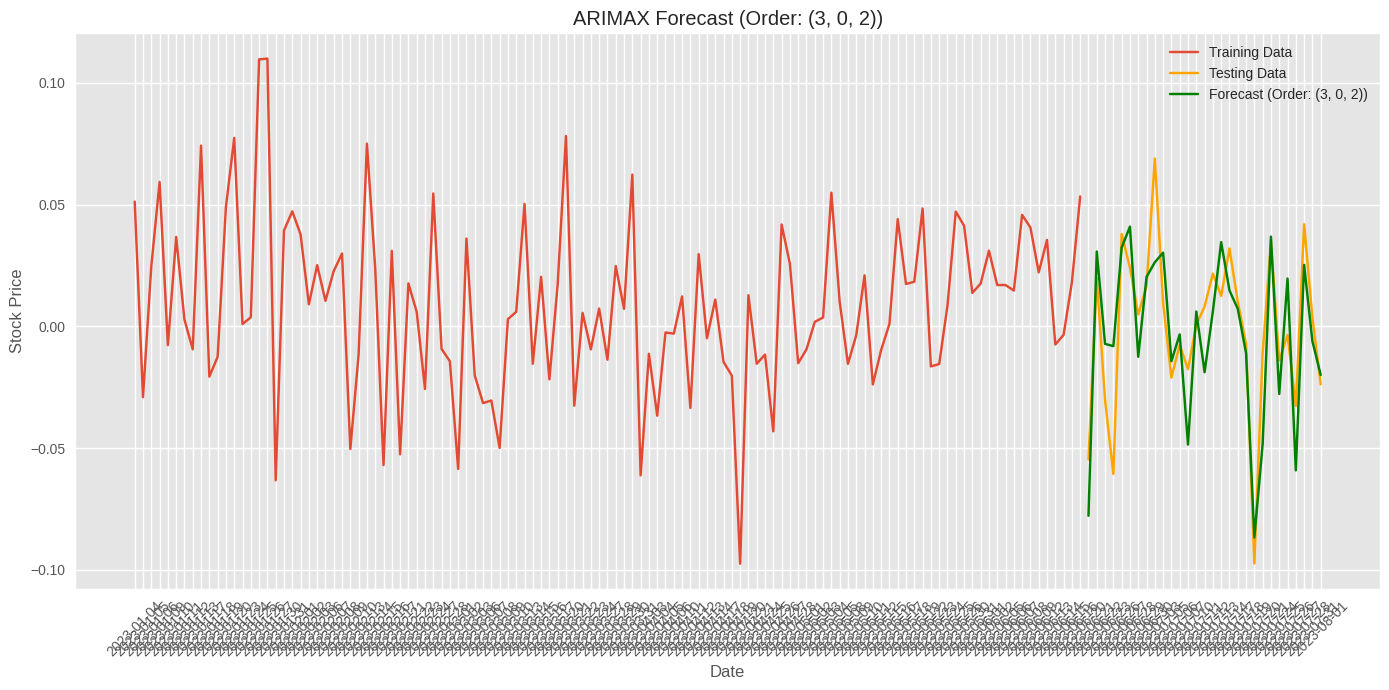

In [ ]:
arimax_model.walk_forward_validation()


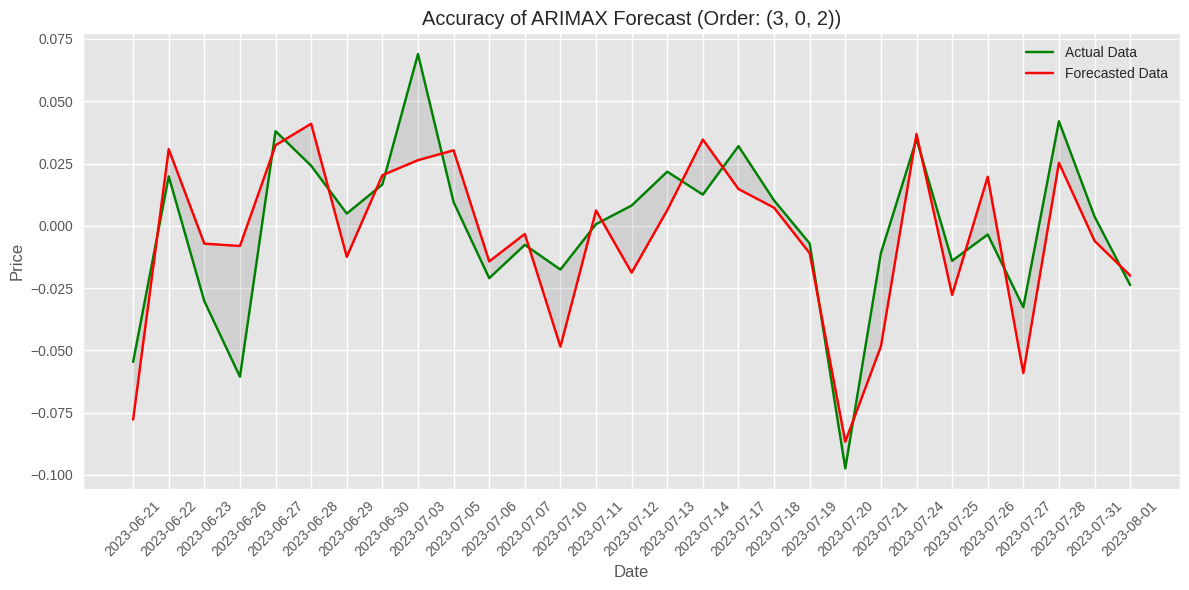

In [ ]:
arimax_model.plot_accuracy()

In [ ]:
arimax_model.print_evaluation_metrics()

Final Mean Squared Error: 0.00044791595799392167
Final Mean Absolute Error: 0.017127898047642566
Final Root Mean Squared Error: 0.021164025089616616


In [ ]:
arimax_model.print_model_summary()

                               ARIMA Results                                
Dep. Variable:       Close_pct_change   No. Observations:                  115
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 257.103
Date:                Thu, 08 Aug 2024   AIC                           -492.206
Time:                        22:09:55   BIC                           -462.012
Sample:                             0   HQIC                          -479.951
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0076   5.22e-08  -1.46e+05      0.000      -0.008      -0.008
Volume      1.769e-10   4.45e-11      3.979      0.000    8.97e-11    2.64e-10
Open          -0.0084   1.57e-05   -533.119      0.000

## 4.3 Autoregressive fractionally integrated moving average (AFRIMA)

In [ ]:
class AFRIMAModel:
    def __init__(self, ticker, start_date, end_date, exog_vars):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.exog_vars = exog_vars
        self.model_order = (0, 1, 0)
        self.train = None
        self.test = None
        self.train_exog = None
        self.test_exog = None
        self.dataset_ex_df = None
        self.history = None
        self.history_exog = None
        self.predictions = []
        self.best_orders = []

    def download_data(self):
        ticker = yf.Ticker(self.ticker)
        self.dataset_ex_df = ticker.history(start=self.start_date, end=self.end_date)
        self.dataset_ex_df.reset_index(inplace=True)
        self.dataset_ex_df['Date'] = pd.to_datetime(self.dataset_ex_df['Date'])
        self.dataset_ex_df.set_index('Date', inplace=True)

        # Drop any rows with missing values
        self.dataset_ex_df.dropna(inplace=True)

        print("Data downloaded and processed. Shape of the dataset:")
        print(self.dataset_ex_df.shape)
        print("\nFirst few rows of the dataset:")
        print(self.dataset_ex_df.head())

    def determine_afrima_order(self):
        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        model = auto_arima(endog, exogenous=exog, seasonal=False, trace=True, suppress_warnings=True, with_intercept=False)
        self.model_order = model.order
        print("Best AFRIMA model order:", self.model_order)
        print("Model summary:")
        print(model.summary())

    def grid_search_afrima_order(self):
        p_values = range(0, 6)
        d_values = [0.5]  # Fractionally integrated
        q_values = range(0, 6)
        results = []

        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = auto_arima(endog, exogenous=exog, order=(p, d, q), seasonal=False, suppress_warnings=True, with_intercept=False)
                        model_fit = model.fit(endog, exogenous=exog)
                        mse = mean_squared_error(endog, model_fit.predict_in_sample())
                        results.append(((p, d, q), mse, model_fit))
                        print(f'AFRIMA order {(p, d, q)} MSE={mse}')
                    except Exception as e:
                        continue

        results.sort(key=lambda x: x[1])
        self.best_orders = results[:5]
        self.model_order = self.best_orders[0][0]

        metrics = ['Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC']
        metrics_data = []

        for order, mse, model_fit in self.best_orders:
            y_true = endog
            y_pred = model_fit.predict_in_sample()
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
            mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))  # naive forecast method
            r_squared = r2_score(y_true, y_pred)
            adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - len(model_fit.params()) - 1)
            aic = model_fit.aic()
            bic = model_fit.bic()

            metrics_data.append([order, mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic])

        best_orders_df = pd.DataFrame(metrics_data, columns=metrics)
        print("Top 5 AFRIMA model orders with evaluation metrics:")
        print(best_orders_df)

        return best_orders_df

    def afrima_forecast(self, history, history_exog, exog):
        model = auto_arima(history, exogenous=np.array(history_exog), order=self.model_order, seasonal=False, suppress_warnings=True, with_intercept=False)
        model_fit = model.fit(history, exogenous=np.array(history_exog))
        forecast = model_fit.predict(n_periods=1, exogenous=exog)
        return forecast[0]

    def walk_forward_validation(self, test_size=0.2):
        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        self.train, self.test, self.train_exog, self.test_exog = train_test_split(
            endog, exog, test_size=test_size, shuffle=False
        )

        self.history = [x for x in self.train]
        self.history_exog = self.train_exog.values.tolist()

        for i in range(len(self.test)):
            exog = self.test_exog.iloc[i:i+1].values
            yhat = self.afrima_forecast(self.history, self.history_exog, exog)
            self.predictions.append(yhat)
            obs = self.test.iloc[i]
            self.history.append(obs)
            self.history_exog.append(exog[0])
            print('Predicted: ' + str(yhat) + ', Expected: ' + str(obs))

        mse = np.mean((self.test - self.predictions) ** 2)
        rmse = np.sqrt(mse)
        print('Test RMSE: ' + str(rmse))

        # Plotting the results
        plt.figure(figsize=(14, 7))
        plt.plot(self.train.index, self.train.values, label='Training Data')
        plt.plot(self.test.index, self.test.values, label='Testing Data', color='orange')
        plt.plot(self.test.index, self.predictions, label=f'Forecast (Order: {self.model_order})', color='green')
        plt.title(f'AFRIMA Forecast for {self.ticker} (Order: {self.model_order})')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()


In [ ]:
# Example usage
afrima_model = AFRIMAModel(ticker='TSLA', start_date='2023-01-01', end_date='2023-08-02', exog_vars=['Open', 'High', 'Low', 'Volume'])

Data downloaded and processed. Shape of the dataset:
(145, 7)

First few rows of the dataset:
                                 Open        High         Low       Close  \
Date                                                                        
2023-01-03 00:00:00-05:00  118.470001  118.800003  104.639999  108.099998   
2023-01-04 00:00:00-05:00  109.110001  114.589996  107.519997  113.639999   
2023-01-05 00:00:00-05:00  110.510002  111.750000  107.160004  110.339996   
2023-01-06 00:00:00-05:00  103.000000  114.389999  101.809998  113.059998   
2023-01-09 00:00:00-05:00  118.959999  123.519997  117.110001  119.769997   

                              Volume  Dividends  Stock Splits  
Date                                                           
2023-01-03 00:00:00-05:00  231402800        0.0           0.0  
2023-01-04 00:00:00-05:00  180389000        0.0           0.0  
2023-01-05 00:00:00-05:00  157986300        0.0           0.0  
2023-01-06 00:00:00-05:00  220911100        0.

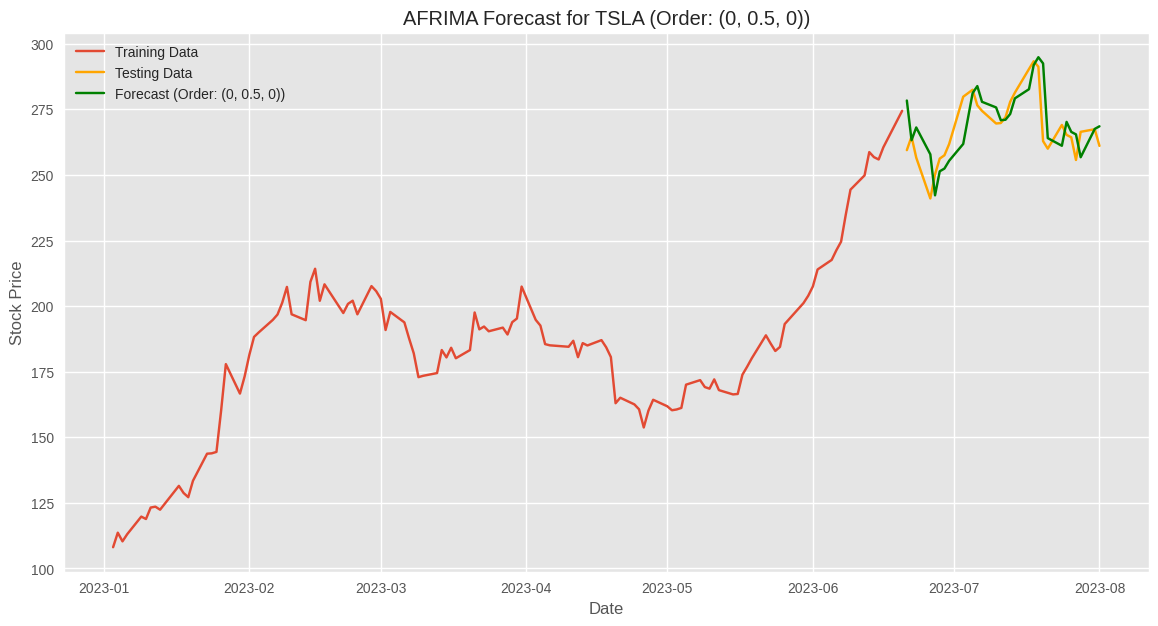

In [ ]:
afrima_model.download_data()
best_orders_df = afrima_model.grid_search_afrima_order()  # Grid search for the best order
afrima_model.walk_forward_validation()

In [ ]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
from sklearn.model_selection import train_test_split

class AFRIMAModel:
    def __init__(self, train, test, train_exog, test_exog, exog_vars):
        """
        Initializes the AFRIMAModel with the given parameters.

        Parameters:
        train (pd.Series): The training dataset.
        test (pd.Series): The testing dataset.
        train_exog (pd.DataFrame): The training exogenous variables.
        test_exog (pd.DataFrame): The testing exogenous variables.
        exog_vars (list): List of exogenous variables to include in the model.
        """
        self.train = train
        self.test = test
        self.train_exog = train_exog
        self.test_exog = test_exog
        self.exog_vars = exog_vars
        self.model_order = (0, 1, 0)
        self.history = list(train)
        self.history_exog = train_exog.values.tolist()
        self.predictions = []
        self.best_orders = []
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    def determine_afrima_order(self):
        """
        Determines the best AFRIMA model order using auto_arima.
        """
        endog = self.train
        exog = self.train_exog

        model = auto_arima(endog, exogenous=exog, seasonal=False, trace=True, suppress_warnings=True, with_intercept=False)
        self.model_order = model.order
        print("Best AFRIMA model order:", self.model_order)
        print("Model summary:")
        print(model.summary())

    def grid_search_afrima_order(self):
        """
        Performs a grid search to find the best AFRIMA model order.
        """
        p_values = range(0, 6)
        d_values = [0.5]  # Fractionally integrated
        q_values = range(0, 6)
        results = []

        endog = self.train
        exog = self.train_exog

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = auto_arima(endog, exogenous=exog, order=(p, d, q), seasonal=False, suppress_warnings=True, with_intercept=False)
                        model_fit = model.fit(endog, exogenous=exog)
                        mse = mean_squared_error(endog, model_fit.predict_in_sample())
                        results.append(((p, d, q), mse, model_fit))
                        print(f'AFRIMA order {(p, d, q)} MSE={mse}')
                    except Exception as e:
                        continue

        results.sort(key=lambda x: x[1])
        self.best_orders = results[:5]
        self.model_order = self.best_orders[0][0]

        metrics = ['Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC']
        metrics_data = []

        for order, mse, model_fit in self.best_orders:
            y_true = endog
            y_pred = model_fit.predict_in_sample()
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
            mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))  # naive forecast method
            r_squared = r2_score(y_true, y_pred)
            adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - len(model_fit.params()) - 1)
            aic = model_fit.aic()
            bic = model_fit.bic()

            metrics_data.append([order, mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic])

        best_orders_df = pd.DataFrame(metrics_data, columns=metrics)
        print("Top 5 AFRIMA model orders with evaluation metrics:")
        best_orders_df

        return best_orders_df

    def afrima_forecast(self, history, history_exog, exog):
        """
        Forecasts the next value using the AFRIMA model.

        Parameters:
        history (list): The historical endogenous data.
        history_exog (list): The historical exogenous data.
        exog (array-like): The exogenous variables for the forecast period.

        Returns:
        float: The forecasted value.
        """
        model = auto_arima(history, exogenous=np.array(history_exog), order=self.model_order, seasonal=False, suppress_warnings=True, with_intercept=False)
        model_fit = model.fit(history, exogenous=np.array(history_exog))
        forecast = model_fit.predict(n_periods=1, exogenous=exog)
        return forecast[0]

    def walk_forward_validation(self):
        """
        Performs walk-forward validation on the dataset.
        """
        for i in range(len(self.test)):
            exog = self.test_exog.iloc[i:i+1].values
            yhat = self.afrima_forecast(self.history, self.history_exog, exog)
            self.predictions.append(yhat)
            obs = self.test.iloc[i]
            self.history.append(obs)
            self.history_exog.append(exog[0])
            print('Predicted: ' + str(yhat) + ', Expected: ' + str(obs))

        mse = mean_squared_error(self.test, self.predictions)
        rmse = np.sqrt(mse)
        print('Test RMSE: ' + str(rmse))

        # Plotting the results
        plt.figure(figsize=(14, 7))
        plt.plot(self.train.index, self.train.values, label='Training Data')
        plt.plot(self.test.index, self.test.values, label='Testing Data', color='orange')
        plt.plot(self.test.index, self.predictions, label=f'Forecast (Order: {self.model_order})', color='green')
        plt.title(f'AFRIMA Forecast (Order: {self.model_order})')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
        plt.legend()
        plt.tight_layout()  # Adjust the plot to make sure everything fits without overlap
        plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=751.964, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=758.385, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=760.221, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=760.233, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=754.263, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=755.210, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=754.548, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=754.845, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=753.092, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=754.303, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=752.047, Time=0.21 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 1.347 seconds
Best AFRIMA model order: (2, 1, 2)
Model su

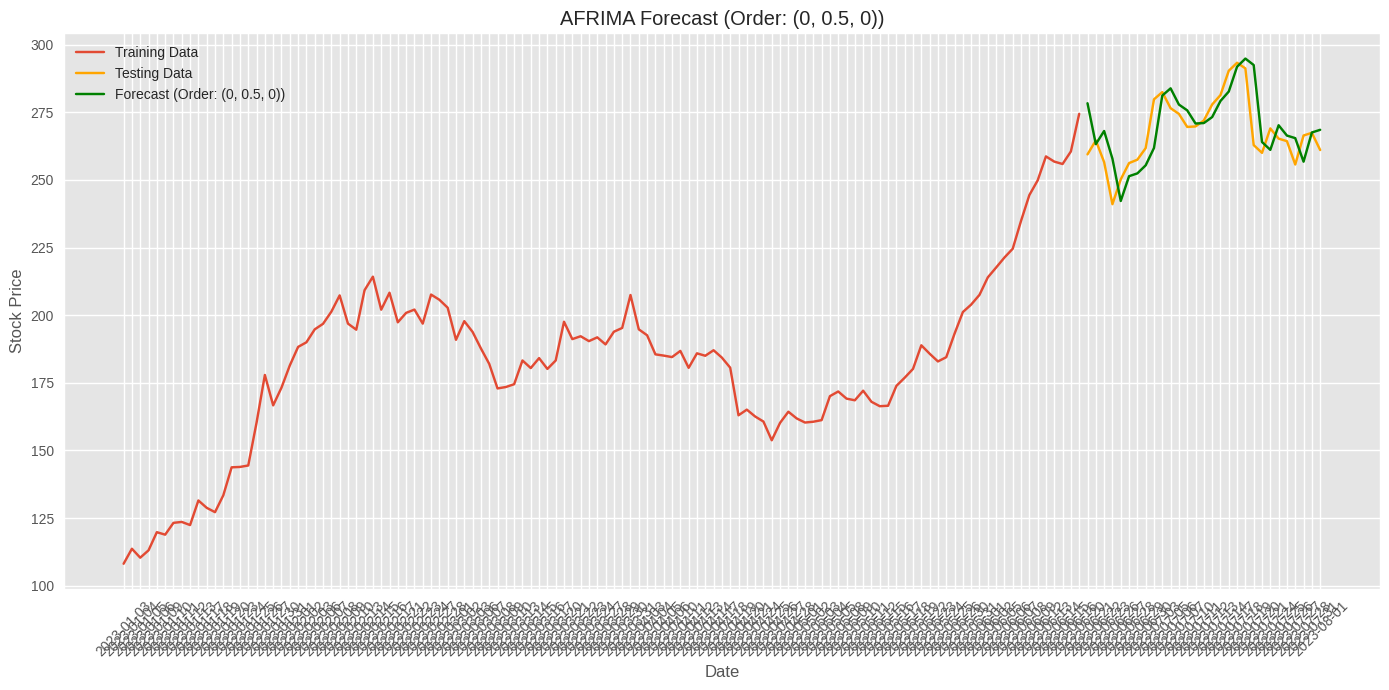

In [ ]:
# Example usage
ticker = yf.Ticker("TSLA")
df = ticker.history(start="2023-01-01", end="2023-08-02")
df.reset_index(inplace=True)
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df.set_index('Date', inplace=True)

# Exogenous variables example (you can customize this as needed)
exog_vars = ['Volume', 'Open', 'High', 'Low']
for var in exog_vars:
    if var not in df.columns:
        raise ValueError(f"Exogenous variable {var} not found in the data.")

# Split the data into training and test sets
train_size = int(len(df['Close']) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

# Split exogenous variables into training and testing sets
train_exog = df[exog_vars].iloc[:train_size]
test_exog = df[exog_vars].iloc[train_size:]

# Initialize the AFRIMAModel
afrima_model = AFRIMAModel(train, test, train_exog, test_exog, exog_vars)

# Run individual steps
afrima_model.determine_afrima_order()
best_orders_df = afrima_model.grid_search_afrima_order()
afrima_model.walk_forward_validation()